# Perceptron for Classification

## You will build a classifier to recognize cats. 

## You will learn to:

- Build the simplest neural network: Perceptron , including:
    - Initializing parameters (e.g. connection weights)
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) to update the parameters
- Merge all three functions above into a main model function.

## Requirements ##

#### Python packages. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

We will build a Perceptron that can correctly classify pictures as cat or non-cat.

**1. Load the data by running the following code.**

In [2]:
hf_train = h5py.File('datasets/train_catvnoncat.h5', 'r')
hf_test = h5py.File('datasets/test_catvnoncat.h5', 'r')

In [3]:
type(hf_train)

h5py._hl.files.File

In [4]:
list(hf_train)
list(hf_test)

['list_classes', 'test_set_x', 'test_set_y']

In [5]:
train_set_x_orig = hf_train.get('train_set_x').value # `data` is now an ndarray.
train_set_y = hf_train.get('train_set_y').value # `data` is now an ndarray.
classes = hf_train.get('list_classes').value # `data` is now an ndarray.

C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [6]:
test_set_x_orig = hf_test.get('test_set_x').value # `data` is now an ndarray.
test_set_y = hf_test.get('test_set_y').value # `data` is now an ndarray.
# classes = hf_train.get('list_classes').value # `data` is now an ndarray.

In [7]:
# print(train_set_x_orig.shape)
# print(test_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_y.shape)

(209,)
(50,)


In [8]:
type(test_set_y)
test_set_y = np.array([test_set_y], np.int64)
train_set_y = np.array([train_set_y], np.int64)
test_set_y.shape

(1, 50)

In [9]:
train_set_y.shape

(1, 209)

In [10]:
# Loading the data (cat/non-cat)
# train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

- We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. 
- After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).
- Each line of train_set_x_orig and test_set_x_orig is an array representing an image. 
- We can visualize an example by running the following code. 

y = [1], it's a 'cat' picture.


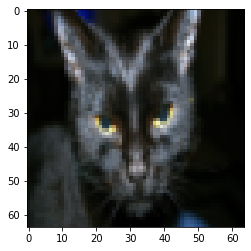

In [11]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

**Find the values** 
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [12]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 1
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


- We have to reshape images of shape (num_px, num_px, 3) into a numpy-array of shape ($num\_px * num\_px * 3$, 1). 
- After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape ($num\_px * num\_px * 3$, 1).

A trick for flattening a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape ($b*c*d$, a) is: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [13]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

- **train_set_x_flatten shape:** (12288, 209)
- **train_set_y shape:** (1, 209)
- **test_set_x_flatten shape** (12288, 50)
- **test_set_y shape:** (1, 50)
- **test_set_x_flatten shape:** (12288, 50)



To represent color images, we have  to specify the red, green and blue channels (RGB) for each pixel, and so the pixel value is actually **a vector of three numbers ranging from 0 to 255**.

- Normolization: For picture datasets, it is to just divide every row of the dataset by 255 (the maximum value of a pixel channel).


In [14]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the data (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- Normorlize the data

## Learning of Perceptron ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(\hat{y^{(i)}}, y^{(i)}) =  \frac{1}{2}(y^{(i)} - \hat{y^{(i)}})^{2}$$

The Cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(\hat{y^{(i)}}, y^{(i)})\tag{6}$$

**Key steps**:
    - Initialize the parameters (weights of the connections between neurons) of the model
    - Learn the parameters for the model by minimizing the Cost (on the training set)
    - Use the learned parameters to make predictions (on the testing set)
    - Analyse and discuss the results

## Building Perceptron ## 

The main steps include:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

We will build 1-3 separately and integrate them into one function we call `model()`.

### 1. Activation Function 

**Implement the activation function `sigmoid()` that is $sigmoid( w^T x + b)$.**

In [15]:
# Activation Function: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [16]:
# Testing sigmoid

print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


### 2. Initializing parameters

**Implement parameter initialization:** initialize $w$ as a vector of zeros. 

In [17]:
# Initializing parameters: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 1
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [18]:
# Testing parameter initialization
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 1


### 3. Forward and Backward propagation

Forward and Backward propagation for learning the parameters.

**Implement a function `propagate()` that computes the cost function and its gradient.**

In this case our activation function is a modified sigmoid with the 5 times the weight and 3 times the bias

- Forward Propagation:
    - Obtain X
    - Compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$, where m is the number of training samples. $X$ is the training set with $\{x_{0}, x_{1}, x_{2}, ..., x_{m}\}$ . $a$ is the predictions with the activation function $\sigma(z) = e^{z}$, where $z = w^T*X + b$  .
    - Calculate the cost function: $J = \frac{1}{m}\sum_{i=1}^{m}(y^{(i)} - a^{(i)})^{2}$

**Two formulas:**

$$ \frac{\partial J}{\partial w} = \frac{-2}{m}X(Y - A)\times A \times (1 - A)\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{-2{m}(Y - A)\times A \times (1 - A)\tag{8}$$

In [19]:
# Propagation

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (1.0/m) * np.sum((Y - A)*(Y - A))   # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    Z1 = np.dot(A,(1 - A).T)
    Z2 = np.dot(X, (Y - A).T)
    dw = (-2.0/ m) * (Z1*Z2)
    db = (-2.0 / m) * np.sum(Z1*(Y - A))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #gradient dictionary
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [20]:
w, b, X, Y = np.array([[3], [5]]), 1, np.array([[2,2], [3,3]]), np.array([[0, 1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[1.11578746e-09]
 [1.67368119e-09]]
db = 5.578937307454209e-10
cost = 0.49999999972105313


### 4. Optimization
- Update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $w$, the update rule is $ w = w - \eta *dw$, where $\eta$ is the learning rate.

In [21]:
# Optimization

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        #print(dw)
        #print (db)
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [22]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[3.]
 [5.]]
b = 0.9999999994978905
dw = [[1.11578746e-09]
 [1.67368119e-09]]
db = 5.578937307454209e-10


### 5. Prediction
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. 

There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. 

In [23]:
# Predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [24]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


## 5. Model ##

- Implement the model function. Use the following notation:
    - Y_prediction for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [25]:
# Model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

**Run the following cell to train your model.**

In [26]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.375248
Cost after iteration 100: 0.344498
Cost after iteration 200: 0.344498
Cost after iteration 300: 0.344498
Cost after iteration 400: 0.344498
Cost after iteration 500: 0.344498
Cost after iteration 600: 0.344498
Cost after iteration 700: 0.344498
Cost after iteration 800: 0.344498
Cost after iteration 900: 0.344498
Cost after iteration 1000: 0.344498
Cost after iteration 1100: 0.344498
Cost after iteration 1200: 0.344498
Cost after iteration 1300: 0.344498
Cost after iteration 1400: 0.344498
Cost after iteration 1500: 0.344498
Cost after iteration 1600: 0.344498
Cost after iteration 1700: 0.344498
Cost after iteration 1800: 0.344498
Cost after iteration 1900: 0.344498
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %


**Comment:** Training accuracy is close to 98%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 72%. 

**Note:** The model is clearly overfitting the training data. 

Label is 1, Prediction is 0


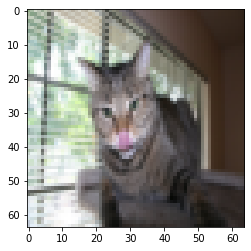

In [27]:
# Example of a picture that was wrongly classified.
index = 20
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("Label is " + str(test_set_y[0][index]) + ", Prediction is " + str(int(d["Y_prediction_test"][0][index])) )

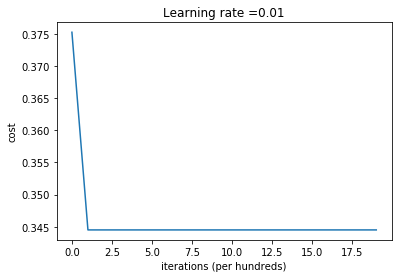

In [28]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [29]:
# Generate Confusion Matrix for accuracy analysis
confusion_matrix_train = confusion_matrix(train_set_y[0], d["Y_prediction_train"][0])
confusion_matrix_test = confusion_matrix(test_set_y[0], d["Y_prediction_test"][0])

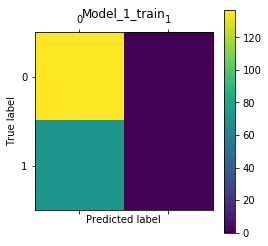

In [30]:
# Plot confusion matrix_train
plt.matshow(confusion_matrix_train)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_1_train")
plt.savefig("test_confusion_matrix_train.png")
plt.show()

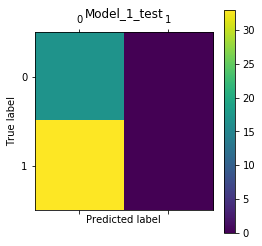

In [31]:
# Plot confusion matrix_test
plt.matshow(confusion_matrix_test)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_1_test")
plt.savefig("test_confusion_matrix_test.png")
plt.show()

## 6. Further analysis

- Different learning rates: [0.01, 0.001, 0.0001]
- Test with your own image

In [32]:
#with learning rate of 0.001, we have this
d2 = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.375248
Cost after iteration 100: 0.344498
Cost after iteration 200: 0.344498
Cost after iteration 300: 0.344498
Cost after iteration 400: 0.344498
Cost after iteration 500: 0.344498
Cost after iteration 600: 0.344498
Cost after iteration 700: 0.344498
Cost after iteration 800: 0.344498
Cost after iteration 900: 0.344498
Cost after iteration 1000: 0.344498
Cost after iteration 1100: 0.344498
Cost after iteration 1200: 0.344498
Cost after iteration 1300: 0.344498
Cost after iteration 1400: 0.344498
Cost after iteration 1500: 0.344498
Cost after iteration 1600: 0.344498
Cost after iteration 1700: 0.344498
Cost after iteration 1800: 0.344498
Cost after iteration 1900: 0.344498
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %


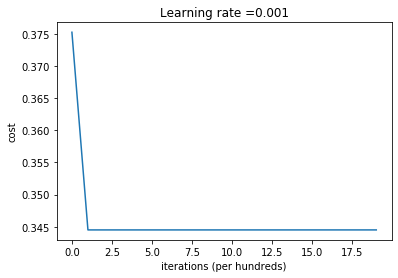

In [33]:
# Plot learning curve (with costs)
costs = np.squeeze(d2['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d2["learning_rate"]))
plt.show()

In [34]:
# Generate Confusion Matrix for accuracy analysis
confusion_matrix_train2 = confusion_matrix(train_set_y[0], d2["Y_prediction_train"][0])
confusion_matrix_test2 = confusion_matrix(test_set_y[0], d2["Y_prediction_test"][0])

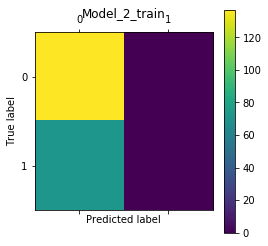

In [35]:
# Plot confusion matrix_train
plt.matshow(confusion_matrix_train2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_2_train")
plt.savefig("test_confusion_matrix_train2.png")
plt.show()

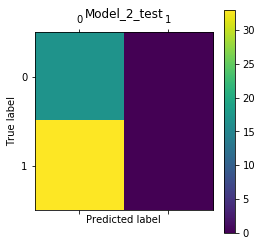

In [36]:
# Plot confusion matrix_test
plt.matshow(confusion_matrix_test2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_2_test")
plt.savefig("test_confusion_matrix_test2.png")
plt.show()

In [37]:
#with learning rate of 0.0001, we have this
d3 = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.375248
Cost after iteration 100: 0.216900
Cost after iteration 200: 0.144240
Cost after iteration 300: 0.124348
Cost after iteration 400: 0.127901
Cost after iteration 500: 0.092503
Cost after iteration 600: 0.066209
Cost after iteration 700: 0.058881
Cost after iteration 800: 0.053247
Cost after iteration 900: 0.048622
Cost after iteration 1000: 0.044746
Cost after iteration 1100: 0.041444
Cost after iteration 1200: 0.038593
Cost after iteration 1300: 0.036104
Cost after iteration 1400: 0.033912
Cost after iteration 1500: 0.031965
Cost after iteration 1600: 0.030224
Cost after iteration 1700: 0.028658
Cost after iteration 1800: 0.027242
Cost after iteration 1900: 0.025955
train accuracy: 99.04306220095694 %
test accuracy: 72.0 %


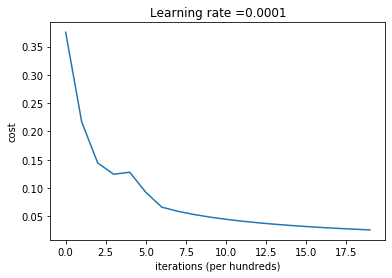

In [38]:
# Plot learning curve (with costs)
costs = np.squeeze(d3['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d3["learning_rate"]))
plt.show()

In [39]:
# Generate Confusion Matrix for accuracy analysis
confusion_matrix_train3 = confusion_matrix(train_set_y[0], d3["Y_prediction_train"][0])
confusion_matrix_test3 = confusion_matrix(test_set_y[0], d3["Y_prediction_test"][0])

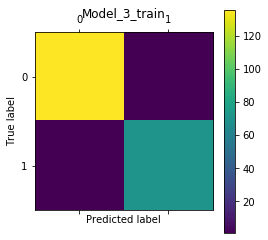

In [40]:
# Plot confusion matrix_train
plt.matshow(confusion_matrix_train3)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_3_train")
plt.savefig("test_confusion_matrix_train3.png")
plt.show()

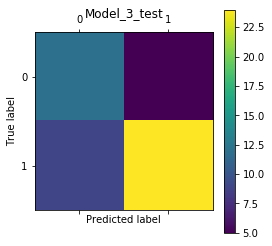

In [41]:
# Plot confusion matrix_test
plt.matshow(confusion_matrix_test3)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Model_3_test")
plt.savefig("test_confusion_matrix_test3.png")
plt.show()